In [1]:
import sys
sys.path.append('E:/zlab/')
from loader import Loader
# ----------------

import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import tables as tb
import mxnet as mx
from mxnet import nd, autograd, gluon
import gluonbook as gb
from mxnet import gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, model_zoo, nn
from sklearn.semi_supervised.label_propagation import LabelSpreading
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score
from mxboard import SummaryWriter

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# 载入数据

In [2]:
import tables as tb

h5 = tb.open_file('E:/xdata/X.h5')
#h5 = tb.open_file('./X.h5')

data = h5.root.cifar10

## 划分数据集

In [3]:
from sklearn.model_selection import train_test_split

X = data.trainX[:]
y = data.trainY[:]
X_train, X_unlabel, y_train, y_unlabel = train_test_split(
    X, y, test_size=0.98, random_state=42)

batch_size = 32
trainset = Loader(batch_size, X_train, y_train, shuffle=True, name='train')
testset = Loader(
    batch_size, data.testX, data.testY, shuffle=False, name='test')
unlabelset = Loader(
    batch_size,
    X_unlabel[:10000],
    y_unlabel[:10000],
    shuffle=False,
    name='agent')

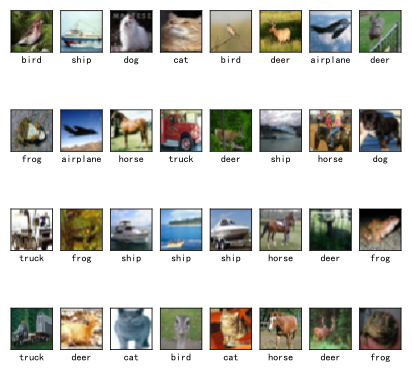

In [4]:
for imgs, labels in iter(trainset):
    trainset.show_imgs(data.label_names, imgs.astype(np.uint8), labels)
    break

# 模型的配置

In [5]:
class SemiModel(nn.HybridBlock):
    def __init__(self, features, **kwargs):
        super().__init__(**kwargs)
        self.features = features
        self.output = nn.Dense(10)
        
    def hybrid_forward(self, F, x):
        x = self.features(x)
        return self.output(x)

pretrain_net = model_zoo.vision.resnet50_v2(pretrained=False)
net = SemiModel(pretrain_net.features)

# 网络预设
_net = model_zoo.vision.resnet50_v2(pretrained=True)
net.features = _net.features
#net.features.add(nn.Flatten())
#net.features[-1].initialize(init.Xavier(magnitude=2.24))
net.output.initialize(init.Xavier(magnitude=2.24))

# 模型超参数设定

In [6]:
from xtrain import XModel

# 超参数设定
epochs = 500
learning_rate = 0.1
model = XModel(learning_rate)
ctx = model.ctx
print('training on', ctx)
net.collect_params().reset_ctx(ctx)
net.hybridize()

training on gpu(0)


# 数据打包

In [7]:
class DataLoader(dict):
    def __init__(self, ctx, batch_size, trainset, unlabelset, *args, **kwargs):
        '''
        初始化数据迭代器和标签传播算法
        '''
        self.__dict__ = self
        self.ctx = ctx
        self.train = trainset
        self.unlabel = unlabelset
        self.X_l = Loader(
            batch_size, self.train.X, shuffle=False, name='x_train')
        self.X_u = Loader(
            batch_size, self.unlabel.X, shuffle=False, name='x_test')
        self.features_u = self.unlabel.X.reshape((-1, 32 * 32 * 3))
        self.features_l = self.train.X.reshape((-1, 32 * 32 * 3))
        _min_max_scaler = MinMaxScaler()
        self.features_l = _min_max_scaler.fit_transform(self.features_l)
        self.features_u = _min_max_scaler.transform(self.features_u)
        self.y_agent = -np.ones_like(self.unlabel.Y)
        self._lbp = LabelSpreading(gamma=0.025, n_jobs=-1, max_iter=100)
        self.ssl()

    def ssl(self):
        '''
        标签传播
        '''
        X = np.concatenate([self.features_l, self.features_u])
        y_ = np.concatenate([trainset.Y, self.y_agent])
        self._lbp.fit(X, y_)  # 必须将 X 缩放到 [0,1]
        self.y_hats = self._lbp.transduction_[self.train.Y.shape[0]:]
        print('分类指标：')
        print(classification_report(self.unlabel.Y, self.y_hats))

    def get_features(self, net, data_iter):
        for x in data_iter:
            x = nd.array(x, ctx=self.ctx).transpose((0, 3, 1, 2))
            features = net.features(x)
            yield features

    def agent(self, net):
        '''
        net:: 神经网络
        inference::输出 net 的 features
        '''
        # 提取有标签数据的特征
        self.features_l = np.concatenate(
            [f.asnumpy() for f in dataset.get_features(net, dataset.X_l)]).astype(np.uint8)
        # 提取无标签数据的特征
        self.features_u = np.concatenate(
            [f.asnumpy() for f in dataset.get_features(net, dataset.X_u)]).astype(np.uint8)
        self.ssl()
        self.agency_acc = accuracy_score(dataset.unlabel.Y, self.y_hats)

dataset = DataLoader(ctx, batch_size, trainset, unlabelset)

分类指标：
             precision    recall  f1-score   support

          0       0.32      0.48      0.38       973
          1       0.50      0.15      0.23       979
          2       0.29      0.09      0.14      1030
          3       0.29      0.03      0.05      1023
          4       0.20      0.44      0.27       933
          5       0.36      0.21      0.26      1015
          6       0.23      0.55      0.32       996
          7       0.58      0.13      0.22       994
          8       0.31      0.64      0.42      1017
          9       0.52      0.23      0.32      1040

avg / total       0.36      0.29      0.26     10000



# 训练和调优

In [8]:
logdir = 'D:/graph/'
sw = SummaryWriter(logdir, flush_secs=5)  # 可视化
y_pre = dataset.y_hats  # 微调前的预测标签
dataset.agent(net)
epoch = 1
while epoch < 500:
    print('微调有标签数据')
    print('~_~' * 25)
    sw.add_scalar('accuracy_curves',
                  {unlabelset.name + '_SSL': dataset.agency_acc}, epoch)
    net = model.train(net, dataset.train, testset, epochs=10, start=epoch)
    dataset.agent(net)
    y_back = dataset.y_hats
    
    print(unlabelset.name + '_SSL: ', dataset.agency_acc)
    epoch += 10
    if -1 in dataset.y_agent:
        dataset.y_agent = y_pre
        dataset.y_agent[dataset.y_hats != y_back] = -1
        
    else:
        break
    X_u_set = Loader(
            batch_size,
            dataset.unlabel.X,
            dataset.y_hats,
            shuffle=True,
            name='train_agent')
    print('-_' * 50)
    print('微调带有代理标签数据')
    net = model.train(net, X_u_set, testset, epochs=1, start=epoch)
    dataset.agent(net)
    epoch += 1

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\semi_supervised\label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


分类指标：
             precision    recall  f1-score   support

          0       0.24      0.29      0.26       973
          1       0.20      0.20      0.20       979
          2       0.18      0.19      0.19      1030
          3       0.16      0.14      0.15      1023
          4       0.19      0.23      0.21       933
          5       0.24      0.21      0.22      1015
          6       0.24      0.25      0.24       996
          7       0.18      0.20      0.19       994
          8       0.31      0.28      0.29      1017
          9       0.22      0.17      0.19      1040

avg / total       0.22      0.21      0.21     10000

微调有标签数据
~_~~_~~_~~_~~_~~_~~_~~_~~_~~_~~_~~_~~_~~_~~_~~_~~_~~_~~_~~_~~_~~_~~_~~_~~_~
Epoch 1, loss 3.77121, train acc 0.126, test_acc 0.1, time 16.3 sec
Epoch 2, loss 2.63895, train acc 0.122, test_acc 0.1454, time 15.8 sec
Epoch 3, loss 2.26138, train acc 0.18, test_acc 0.1384, time 15.9 sec
Epoch 4, loss 2.07224, train acc 0.218, test_acc 0.1618, time 